Robert Kaszubski
CSC 578 - FInal Project


Note: Some of the runtimes may differ from what is reported in my documentation. I reran the whole notebook prior to submission and ran out of GPU runtime on google colab, so the run times will be longer in most cases but results should be similar

I organized everything in sections so it should all be very clear!

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
#Import CSV - taken from assignment instructions
csv_path = tf.keras.utils.get_file(
    origin='https://reed.cs.depaul.edu/peterh/Essays/Metro_Interstate_reduced.csv',
    fname='Metro_Interstate_reduced.csv',
    cache_dir='/content', cache_subdir='sample_data')

csv_path
# should be '/content/sample_data/Metro_Interstate_reduced.csv'

'/content/sample_data/Metro_Interstate_reduced.csv'

# **EXPLORATORY DATA ANALYSIS**

RK. The first step is to examine the variables and variable types in the dataset:

In [3]:
#RK
df = pd.read_csv(csv_path)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


RK. The categorical variables: Holiday, Weather_Main, Weather Description will have to be transformed. I will be converting these into dummy variables or a one hot vector.

The Date_Time object will also have to be transformed

**Distribution of Numeric Variables**

TF. Here is the evolution of a few features over time:

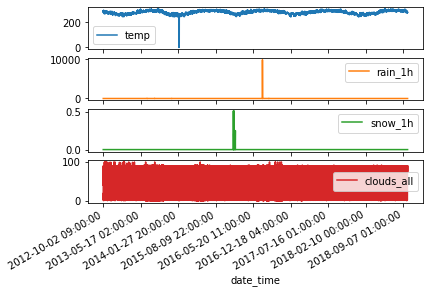

In [4]:
#FROM TF TUTORIAL - MODIFIED
plot_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
plot_features = df[plot_cols]
plot_features.index = df['date_time']
_ = plot_features.plot(subplots=True)

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,40575.0,281.316763,13.816618,0.0,271.84,282.86,292.28,310.07
rain_1h,40575.0,0.318632,48.812640,0.0,0.00,0.00,0.00,9831.30
snow_1h,40575.0,0.000117,0.005676,0.0,0.00,0.00,0.00,0.51
clouds_all,40575.0,44.199162,38.683447,0.0,1.00,40.00,90.00,100.00
traffic_volume,40575.0,3290.650474,1984.772909,0.0,1248.50,3427.00,4952.00,7280.00


RK. We can see a very large max value for rain_1h. It is impossible for it to rain almost 10,000 mm in an hour. We also see a min of 0 for temp, temp is in Kelvin, this figure is also not possible.

Both of these will have to be fixed.

We also get a good idea of how the data is distributed. We can see the statistical summary for each variable which is particularly imporant for numeric variables. For instance, we can see that the vast majority of hours have no rain or snow as the 75 percentile is still 0.

In [6]:
#rk
#setting rain anomaly to 0:
df.loc[df['rain_1h'] >= 400, 'rain_1h'] = 0

In [7]:
#rk
#setting temp anomaly to avg temp:
df.loc[df['temp'] == 0, 'temp'] = 281.3

RK. Confirming the values were properly removed:

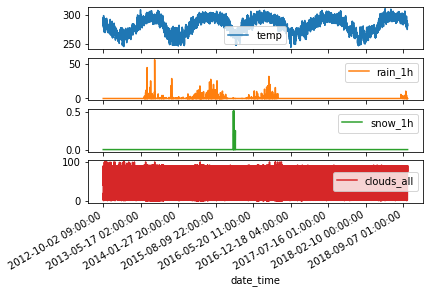

In [8]:
#FROM TF TUTORIAL - MODIFIED
plot_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
plot_features = df[plot_cols]
plot_features.index = df['date_time']
_ = plot_features.plot(subplots=True)

**Histogram of Numeric Variables**

RK. The temperature distribution is almost symetric, it is very close to a normal distribution but perhaps slightly left skewed. Most days the temperature is fairly similar with a few days that were more extreme.

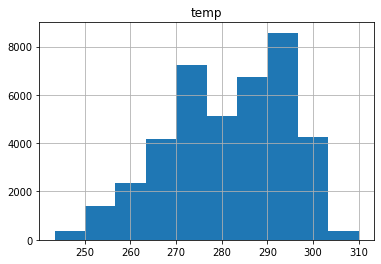

In [9]:
hist = df.hist(column='temp')

RK. The cloud distribution is insteresting as its typically either no clouds or 100% clouds with a few days falling in between.

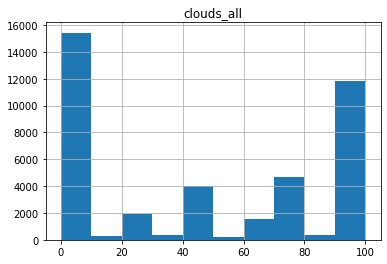

In [10]:
hist = df.hist(column='clouds_all')

RK. As far as rain and snow goes, most hours of the day have no snow or rain. It's fairly rare in this dataset.

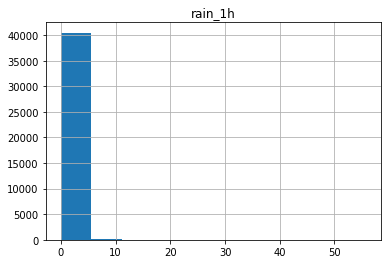

In [11]:
hist = df.hist(column='rain_1h')

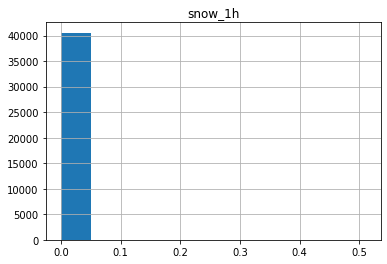

In [12]:
hist = df.hist(column='snow_1h')

RK Using the same steps as in the TF Tutorial, the Date Time variable is converted into time of day and time of year variables. This is an example of feature engineering.

TF. You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals

In [13]:
#FROM TF TUTORIAL
date_time = pd.to_datetime(df.pop('date_time'), format='%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

RK Converting categorical variables to dummy variables (one hot encoding)

In [14]:
#RK
#Converting Categorical variables to dummy variables.
df = pd.get_dummies(df, columns=['holiday','weather_main','weather_description'])

In [15]:
#RK
#not enough instances when splitting dataset, column has to be dropped
#it was resulting in errors when training the model - it only has a single row were it is true (= to 1) so it can be dropped
df = df.drop(columns=["weather_description_proximity thunderstorm with drizzle"])

# **SPLIT TRAINING/VALIDATION/TEST**

In [16]:
#RK
column_indices = {name: i for i, name in enumerate(df.columns)}

#last 5000 records become test set
test_df = df.iloc[-5000:]
rest_df = df.iloc[:-5000, :]

#next 7000 records from the back become validation set
val_df = rest_df.iloc[-7000:]
train_df = rest_df.iloc[:-7000, :] #rest becomes train set

num_features = df.shape[1]


RK. Verify that the number of rows matches the original dataset

In [17]:
len(train_df) + len(val_df) + len(test_df) == len(df)

True

**Normalize**

In [18]:
# FROM TF TUTORIAL
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# **Sample Plot**

In [19]:
# FROM TF TUTORIAL
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [20]:
# FROM TF TUTORIAL
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  #TF
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [21]:
# FROM TF TUTORIAL
def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')
WindowGenerator.plot = plot

**CREATE WINDOW - 7,1,3**

RK. The window has 7 inputs, and a single output that is offset by 3 hours. The total window size should be 10.

In [22]:
window_7_1_3 = WindowGenerator(input_width=7, label_width=1, shift=3, label_columns=['traffic_volume'])
window_7_1_3

Total window size: 10
Input indices: [0 1 2 3 4 5 6]
Label indices: [9]
Label column name(s): ['traffic_volume']

**Sample Test Plot using TF Tutorial Code**

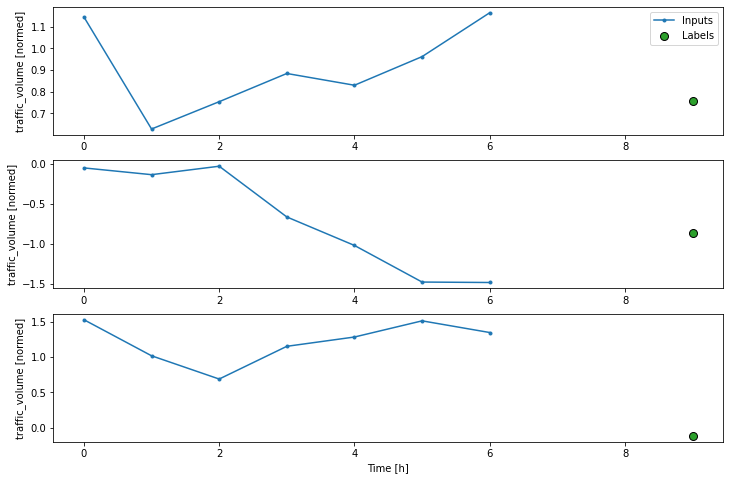

In [23]:
#FROM TF TUTORIAL - MODIFIED
window_size = window_7_1_3.total_window_size #retreive total window size - 10
sample_window = tf.stack([np.array(train_df[:window_size]), #retrieve first 10 rows from training data
                          np.array(train_df[100:100+window_size]), #retrieve rows 101-110 from training data
                          np.array(train_df[200:200+window_size])]) #retrieve rows 201-210 from training data
sample_inputs, sample_labels = window_7_1_3.split_window(sample_window) #retrieve inputs and labels from rows

window_7_1_3.example = sample_inputs, sample_labels
window_7_1_3.plot()




We can see that the window is working properly.

# **MODEL FUNCTIONS**

RK. Tutorial code to turn our split data into batches.

In [24]:
#FROM TF TUTORIAL - MODIFIED
#RK. Changed for only the validation and testing data, that data IS NOT shuffled
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

#RK
#created a new function for just the training dataset
#this one shuffles the data
def make_train_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset
#RK. additional variable in the class for the train dataset function
WindowGenerator.make_train_dataset = make_train_dataset

In [25]:
#FROM TF TUTORIAL - slightly modified
@property
def train(self):
  return self.make_train_dataset(self.train_df)
  #RK. Modified so train uses the new train_dataset function

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

RK. Tutorial function to train and evaluate a model. Uses early stopage that I modified to restore the best weights and I parameterized total epochs for ease of testing

In [26]:
#FROM TF TUTORIAL - MODIFIED
#RK. ADDED restore best weights, and turned max epochs into a parameter for easier testing
def compile_and_fit(model, window, patience=10, epochs=50):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights = True)

  model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])

  return history

RK. Function I created to create prediction CSV. Takes in a model and window object. Creates prediction set, denormalizes it and outputs it in the proper format for KAGGLE.

In [27]:
#RK. I wrote this function to take in a model and window and return a csv with the predictions
def make_predictions(model,window):
  #RK make predictions
  prediction = model.predict(window.test) 

  #RK denormalize predictions
  predictions = (prediction * train_std['traffic_volume']) + train_mean['traffic_volume'] 

  #RK add ID and format rows for output
  output = []
  output.append(['id','prediction'])
  count = 1
  for row in predictions:
    prediction = [count] + row.tolist()
    output.append(prediction)
    count += 1
  
  #RK write to csv for submission
  import csv
  with open('FinalPredictions.csv','w') as f:
    writer = csv.writer(f)
    for row in output:
      writer.writerow(row)




RK. Function I created to plot MAE of training vs validation, as well as loss of training vs validation

In [28]:
def plot_results(history):
  plt.plot(history.history['mean_absolute_error'], label='training MAE') 
  plt.plot(history.history['val_mean_absolute_error'], label = 'valid. MAE') 
  plt.xlabel('Epoch')
  plt.ylabel('MAE')
  plt.ylim([0.0, 0.5])
  plt.legend(loc='upper right')

  plt.plot(history.history['loss'], label='training loss') 
  plt.plot(history.history['val_loss'], label = 'valid. loss') 
  plt.xlabel('Epoch')
  plt.ylabel('value')
  plt.ylim([0.0, 0.5])
  plt.legend(loc='upper right')


**BUILDING MODELS - ALL CODE FROM THIS POINT IS COMPLETLY MINE**

# **BASELINE MODEL**

In [29]:
baseline_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(7),
    tf.keras.layers.Dense(units=1)
])


In [30]:
hist = compile_and_fit(baseline_model, window_7_1_3, 10, 50)

Epoch 1/50
893/893 [==============================] - 6s 5ms/step - loss: 0.4171 - mean_absolute_error: 0.4782 - val_loss: 0.2542 - val_mean_absolute_error: 0.3627
Epoch 2/50
893/893 [==============================] - 4s 4ms/step - loss: 0.2832 - mean_absolute_error: 0.3690 - val_loss: 0.2147 - val_mean_absolute_error: 0.3251
Epoch 3/50
893/893 [==============================] - 4s 4ms/step - loss: 0.2552 - mean_absolute_error: 0.3443 - val_loss: 0.1959 - val_mean_absolute_error: 0.3050
Epoch 4/50
893/893 [==============================] - 4s 4ms/step - loss: 0.2356 - mean_absolute_error: 0.3277 - val_loss: 0.1801 - val_mean_absolute_error: 0.2896
Epoch 5/50
893/893 [==============================] - 4s 5ms/step - loss: 0.2198 - mean_absolute_error: 0.3130 - val_loss: 0.1634 - val_mean_absolute_error: 0.2735
Epoch 6/50
893/893 [==============================] - 4s 5ms/step - loss: 0.2047 - mean_absolute_error: 0.3004 - val_loss: 0.1511 - val_mean_absolute_error: 0.2618
Epoch 7/50
893/8

In [31]:
make_predictions(baseline_model, window_7_1_3)

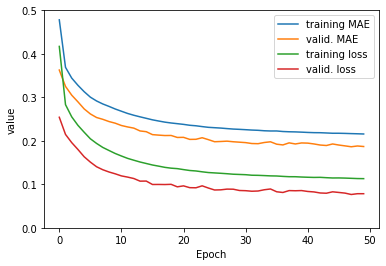

In [32]:
plot_results(hist)

# **PARAMETER TUNING: NUMBER OF UNITS**

In [33]:
unit_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(9),
    tf.keras.layers.Dense(units=1)
])


In [34]:
hist = compile_and_fit(unit_model, window_7_1_3, 10, 50)

Epoch 1/50
893/893 [==============================] - 7s 5ms/step - loss: 0.4408 - mean_absolute_error: 0.4968 - val_loss: 0.2681 - val_mean_absolute_error: 0.3714
Epoch 2/50
893/893 [==============================] - 5s 6ms/step - loss: 0.2912 - mean_absolute_error: 0.3747 - val_loss: 0.2277 - val_mean_absolute_error: 0.3326
Epoch 3/50
893/893 [==============================] - 5s 6ms/step - loss: 0.2567 - mean_absolute_error: 0.3422 - val_loss: 0.2074 - val_mean_absolute_error: 0.3141
Epoch 4/50
893/893 [==============================] - 5s 6ms/step - loss: 0.2345 - mean_absolute_error: 0.3246 - val_loss: 0.1934 - val_mean_absolute_error: 0.3015
Epoch 5/50
893/893 [==============================] - 6s 6ms/step - loss: 0.2196 - mean_absolute_error: 0.3114 - val_loss: 0.1793 - val_mean_absolute_error: 0.2863
Epoch 6/50
893/893 [==============================] - 6s 6ms/step - loss: 0.2079 - mean_absolute_error: 0.3017 - val_loss: 0.1729 - val_mean_absolute_error: 0.2809
Epoch 7/50
893/8

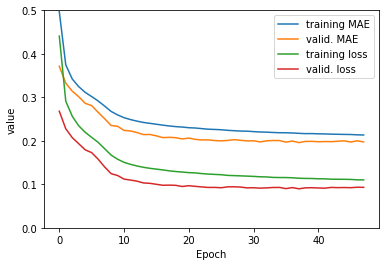

In [35]:
plot_results(hist)

In [36]:
make_predictions(unit_model, window_7_1_3)

# **PARAMETER TUNING: ADDITION OF RECURENT LAYERS**

In [37]:
layer_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(9),
    tf.keras.layers.Dense(units=1)
])

In [38]:
hist = compile_and_fit(layer_model, window_7_1_3, 10, 50)

Epoch 1/50
893/893 [==============================] - 33s 26ms/step - loss: 0.4687 - mean_absolute_error: 0.5163 - val_loss: 0.2741 - val_mean_absolute_error: 0.3954
Epoch 2/50
893/893 [==============================] - 22s 25ms/step - loss: 0.3397 - mean_absolute_error: 0.4107 - val_loss: 0.2350 - val_mean_absolute_error: 0.3573
Epoch 3/50
893/893 [==============================] - 23s 26ms/step - loss: 0.2836 - mean_absolute_error: 0.3682 - val_loss: 0.2011 - val_mean_absolute_error: 0.3273
Epoch 4/50
893/893 [==============================] - 23s 26ms/step - loss: 0.2399 - mean_absolute_error: 0.3360 - val_loss: 0.1701 - val_mean_absolute_error: 0.2936
Epoch 5/50
893/893 [==============================] - 23s 26ms/step - loss: 0.2066 - mean_absolute_error: 0.3064 - val_loss: 0.1527 - val_mean_absolute_error: 0.2782
Epoch 6/50
893/893 [==============================] - 23s 26ms/step - loss: 0.1861 - mean_absolute_error: 0.2868 - val_loss: 0.1321 - val_mean_absolute_error: 0.2545
Epoc

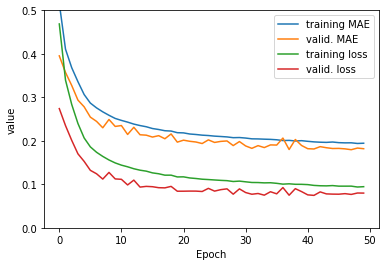

In [39]:
plot_results(hist)

# **PARAMETER TUNING: LAYERS AND UNITS**

In [40]:
layerunit_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(3),
    tf.keras.layers.Dense(units=1)
])

In [41]:
hist = compile_and_fit(layerunit_model, window_7_1_3, 20, 50)

Epoch 1/50
893/893 [==============================] - 26s 21ms/step - loss: 0.4475 - mean_absolute_error: 0.5038 - val_loss: 0.3024 - val_mean_absolute_error: 0.4168
Epoch 2/50
893/893 [==============================] - 18s 20ms/step - loss: 0.3111 - mean_absolute_error: 0.3877 - val_loss: 0.2465 - val_mean_absolute_error: 0.3659
Epoch 3/50
893/893 [==============================] - 18s 20ms/step - loss: 0.2609 - mean_absolute_error: 0.3479 - val_loss: 0.1986 - val_mean_absolute_error: 0.3185
Epoch 4/50
893/893 [==============================] - 17s 19ms/step - loss: 0.2197 - mean_absolute_error: 0.3146 - val_loss: 0.1553 - val_mean_absolute_error: 0.2697
Epoch 5/50
893/893 [==============================] - 17s 19ms/step - loss: 0.1901 - mean_absolute_error: 0.2881 - val_loss: 0.1386 - val_mean_absolute_error: 0.2539
Epoch 6/50
893/893 [==============================] - 17s 19ms/step - loss: 0.1749 - mean_absolute_error: 0.2742 - val_loss: 0.1346 - val_mean_absolute_error: 0.2419
Epoc

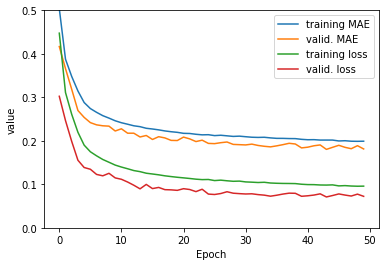

In [42]:
plot_results(hist)

# **PARAMETER TUNING: ADDITIONAL DENSE LAYERS (Runner UP Model)**

In [43]:
dense_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(3),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(units=9),
    tf.keras.layers.Dense(units=3),
    tf.keras.layers.Dense(units=1)
])

In [44]:
hist = compile_and_fit(dense_model, window_7_1_3, 20, 50)

Epoch 1/50
893/893 [==============================] - 25s 20ms/step - loss: 0.4594 - mean_absolute_error: 0.5078 - val_loss: 0.2477 - val_mean_absolute_error: 0.3691
Epoch 2/50
893/893 [==============================] - 17s 19ms/step - loss: 0.3520 - mean_absolute_error: 0.4273 - val_loss: 0.2329 - val_mean_absolute_error: 0.3488
Epoch 3/50
893/893 [==============================] - 17s 19ms/step - loss: 0.3141 - mean_absolute_error: 0.4003 - val_loss: 0.2171 - val_mean_absolute_error: 0.3414
Epoch 4/50
893/893 [==============================] - 17s 19ms/step - loss: 0.2771 - mean_absolute_error: 0.3747 - val_loss: 0.1694 - val_mean_absolute_error: 0.2934
Epoch 5/50
893/893 [==============================] - 17s 19ms/step - loss: 0.2486 - mean_absolute_error: 0.3528 - val_loss: 0.1580 - val_mean_absolute_error: 0.2766
Epoch 6/50
893/893 [==============================] - 17s 18ms/step - loss: 0.2230 - mean_absolute_error: 0.3306 - val_loss: 0.1277 - val_mean_absolute_error: 0.2504
Epoc

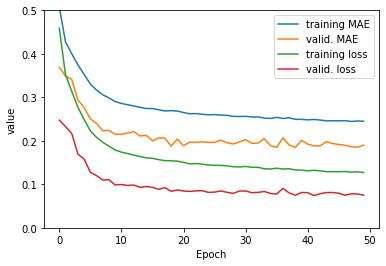

In [45]:
plot_results(hist)

In [46]:
make_predictions(dense_model, window_7_1_3)

# **EXPERIMENT: BIDIRECTIONAL RNN**

In [47]:
bi_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=1)
])

In [48]:
hist = compile_and_fit(bi_model, window_7_1_3, 20, 50)

Epoch 1/50
893/893 [==============================] - 37s 26ms/step - loss: 0.3737 - mean_absolute_error: 0.4408 - val_loss: 0.2256 - val_mean_absolute_error: 0.3339
Epoch 2/50
893/893 [==============================] - 21s 23ms/step - loss: 0.2519 - mean_absolute_error: 0.3400 - val_loss: 0.1726 - val_mean_absolute_error: 0.2898
Epoch 3/50
893/893 [==============================] - 21s 23ms/step - loss: 0.2003 - mean_absolute_error: 0.2967 - val_loss: 0.1235 - val_mean_absolute_error: 0.2387
Epoch 4/50
893/893 [==============================] - 21s 23ms/step - loss: 0.1718 - mean_absolute_error: 0.2700 - val_loss: 0.1155 - val_mean_absolute_error: 0.2288
Epoch 5/50
893/893 [==============================] - 20s 23ms/step - loss: 0.1595 - mean_absolute_error: 0.2578 - val_loss: 0.1050 - val_mean_absolute_error: 0.2153
Epoch 6/50
893/893 [==============================] - 21s 23ms/step - loss: 0.1512 - mean_absolute_error: 0.2492 - val_loss: 0.1010 - val_mean_absolute_error: 0.2166
Epoc

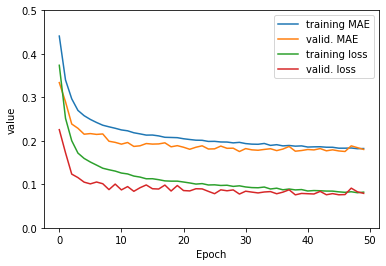

In [49]:
plot_results(hist)

# **PARAMETER TUNING: DROPOUT**

In [50]:
dropout_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(9, recurrent_dropout=.5, return_sequences=True),
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(3),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(units=9),
    tf.keras.layers.Dense(units=3),
    tf.keras.layers.Dense(units=1)
])

In [51]:
hist = compile_and_fit(dropout_model, window_7_1_3, 20, 50)

Epoch 1/50
893/893 [==============================] - 28s 22ms/step - loss: 0.4555 - mean_absolute_error: 0.5040 - val_loss: 0.2279 - val_mean_absolute_error: 0.3506
Epoch 2/50
893/893 [==============================] - 19s 21ms/step - loss: 0.3424 - mean_absolute_error: 0.4203 - val_loss: 0.2014 - val_mean_absolute_error: 0.3278
Epoch 3/50
893/893 [==============================] - 19s 21ms/step - loss: 0.2895 - mean_absolute_error: 0.3845 - val_loss: 0.1597 - val_mean_absolute_error: 0.2886
Epoch 4/50
893/893 [==============================] - 19s 21ms/step - loss: 0.2514 - mean_absolute_error: 0.3575 - val_loss: 0.1373 - val_mean_absolute_error: 0.2647
Epoch 5/50
893/893 [==============================] - 19s 21ms/step - loss: 0.2305 - mean_absolute_error: 0.3413 - val_loss: 0.1196 - val_mean_absolute_error: 0.2416
Epoch 6/50
893/893 [==============================] - 19s 21ms/step - loss: 0.2180 - mean_absolute_error: 0.3291 - val_loss: 0.1161 - val_mean_absolute_error: 0.2344
Epoc

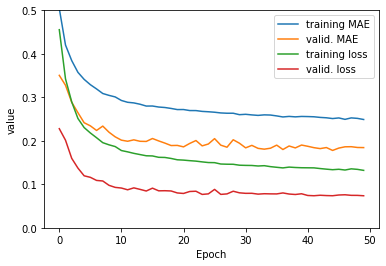

In [52]:
plot_results(hist)

# **Best Model**

In [57]:
final_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(9, return_sequences=True),
    tf.keras.layers.LSTM(3),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=1)
])

In [59]:
hist = compile_and_fit(final_model, window_7_1_3, 20, 50)

Epoch 1/50
893/893 [==============================] - 24s 21ms/step - loss: 0.1599 - mean_absolute_error: 0.2624 - val_loss: 0.1055 - val_mean_absolute_error: 0.2254
Epoch 2/50
893/893 [==============================] - 17s 19ms/step - loss: 0.1519 - mean_absolute_error: 0.2544 - val_loss: 0.1036 - val_mean_absolute_error: 0.2228
Epoch 3/50
893/893 [==============================] - 16s 18ms/step - loss: 0.1470 - mean_absolute_error: 0.2487 - val_loss: 0.1036 - val_mean_absolute_error: 0.2229
Epoch 4/50
893/893 [==============================] - 17s 19ms/step - loss: 0.1414 - mean_absolute_error: 0.2434 - val_loss: 0.0984 - val_mean_absolute_error: 0.2136
Epoch 5/50
893/893 [==============================] - 17s 19ms/step - loss: 0.1383 - mean_absolute_error: 0.2404 - val_loss: 0.1044 - val_mean_absolute_error: 0.2219
Epoch 6/50
893/893 [==============================] - 17s 19ms/step - loss: 0.1342 - mean_absolute_error: 0.2366 - val_loss: 0.0917 - val_mean_absolute_error: 0.2098
Epoc

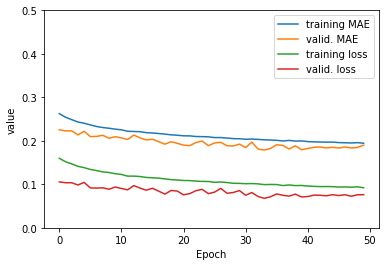

In [60]:
plot_results(hist)

In [61]:
make_predictions(final_model, window_7_1_3)